In [1]:
!pip -q install albumentations
import tensorflow as tf
from matplotlib import pyplot as plt
import os
import numpy as np
import albumentations
import time

#### Parameters

In [2]:

IMG_SHAPE = (128, 128, 3)
BATCH_SIZE = 16
CLASSES = {
    0:'patrik',
    1: "spongebob",
    2: "squidward",
}

EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, patience=3, restore_best_weights=True)

callbacks = [early_stopping]

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy()

def get_model():
    extractor = tf.keras.Sequential()
    extractor.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=IMG_SHAPE))
    # extractor.add(tf.keras.layers.MaxPooling2D())
    extractor.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
    extractor.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    # extractor.add(tf.keras.layers.MaxPooling2D())
    extractor.add(tf.keras.layers.Flatten())
    extractor.add(tf.keras.layers.Dense(units=120, activation='relu'))
    extractor.add(tf.keras.layers.Dense(units=84, activation='relu'))
    extractor.add(tf.keras.layers.Dense(units=3, activation = 'softmax'))
    return extractor


In [3]:
def draw_examples(examples):
    _, axes = plt.subplots(nrows=1, ncols=BATCH_SIZE, figsize=(20, 20))
    plt.setp(axes, xticks=[], yticks=[])
    x, y = examples
    for id in range(BATCH_SIZE):
        image, label = x[id], y[id]
        arr_ = np.squeeze(image)
        axes[id].imshow(image)
        index = tf.math.argmax(label, output_type=tf.int32, axis=0)
        axes[id].set_xlabel(CLASSES[index.numpy()])
    plt.show()


In [4]:
dataset_path = './dataset/train/'
if not os.path.isdir(dataset_path):
    !unzip -q dataset.zip

In [5]:
def make_dataset(generator, dataset_path):
    train = generator.flow_from_directory(
        batch_size=BATCH_SIZE,
        directory=dataset_path,
        target_size=(IMG_SHAPE[0], IMG_SHAPE[1]),
        subset="training",
        class_mode='categorical',
    )

    test = generator.flow_from_directory(
        batch_size=BATCH_SIZE,
        directory=dataset_path,
        target_size=(IMG_SHAPE[0], IMG_SHAPE[1]),
        subset="validation",
        class_mode='categorical',
    )
    return train, test

#### Without Augmentation

In [6]:
# tf.keras.backend.clear_session()
#
# image_generator_none =  tf.keras.preprocessing.image.ImageDataGenerator(
#     validation_split=0.2,
#     rescale=1/255.,
# )
#
# train_dataset_none, test_dataset = make_dataset(image_generator_none)
#
# examples_none = train_dataset_none[0]
# print(len(examples_none[0][0]))
# draw_examples(examples_none)


In [7]:
# model_none = get_model()
# model_none.summary()
#
# model_none.compile(
#     optimizer=optimizer,
#     loss=loss,
#     metrics=[metrics])
#
#
#
# history_none = model_none.fit(train_dataset_none,
#                                  validation_data=test_dataset,
#                                  epochs=EPOCHS,
#                                  callbacks=callbacks)

#### Default augmentation

Found 517 images belonging to 3 classes.
Found 128 images belonging to 3 classes.


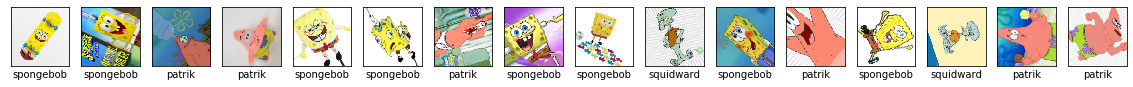

In [8]:
image_generator_default =  tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    rescale=1/255.,
    validation_split=0.2,
)

train_dataset_default, test_dataset_default = make_dataset(image_generator_default)
examples_default = train_dataset_default[0]
draw_examples(examples_default)

In [9]:
model_default = get_model()

model_default.summary()

model_default.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"])

history_default = model_default.fit(train_dataset_default,
                                 validation_data=test_dataset_default,
                                 epochs=EPOCHS,
                                 callbacks=callbacks)
model_default.save("model_default.h5")
model_default = None

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 6)       456       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 16)      2416      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 118, 118, 32)      4640      
_________________________________________________________________
flatten (Flatten)            (None, 445568)            0         
_________________________________________________________________
dense (Dense)                (None, 120)               53468280  
_________________________________________________________________
dense_1 (Dense)              (None, 84)                10164     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 2

In [20]:
#### Default augmentation with using cutout

In [21]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        input_img = input_img
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img
    return eraser

Found 517 images belonging to 3 classes.
Found 128 images belonging to 3 classes.


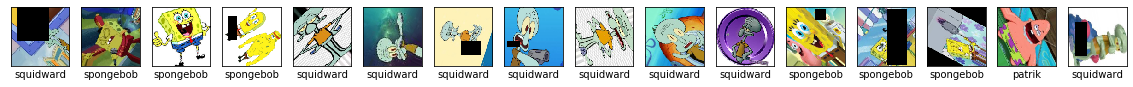

In [12]:
image_generator_cutout =  tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    preprocessing_function=get_random_eraser(v_l=0.1, v_h=0.4, p=0.4),
    rescale=1/255.,
    validation_split=0.2,

)

train_dataset_cutout, test_dataset_cutout = make_dataset(image_generator_cutout)
examples_albumentations_cutout = train_dataset_cutout[0]
draw_examples(examples_albumentations_cutout)

In [13]:
model_cutout = get_model()

print(model_default is model_cutout)
model_cutout.summary()

model_cutout.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"])

history_cutout = model_cutout.fit(train_dataset_cutout,
                                 validation_data=test_dataset_cutout,
                                 epochs=EPOCHS,
                                 callbacks=callbacks)

model_cutout.save("model_cutout.h5")
model_cutout = None

False
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 124, 124, 6)       456       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 120, 120, 16)      2416      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 118, 118, 32)      4640      
_________________________________________________________________
flatten_1 (Flatten)          (None, 445568)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               53468280  
_________________________________________________________________
dense_4 (Dense)              (None, 84)                10164     
_________________________________________________________________
dense_5 (Dense)              (None, 3)          

In [14]:
#### Default augmentation with using albumentations

Found 517 images belonging to 3 classes.
Found 128 images belonging to 3 classes.


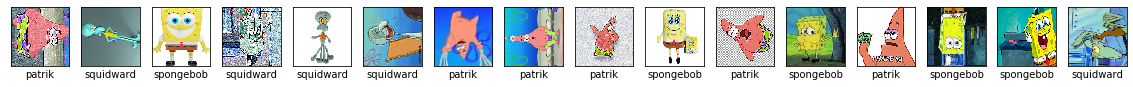

In [15]:
def albumentations_example(x):
    AUGMENTATIONS = albumentations.Compose([
        albumentations.RandomRotate90(),
        albumentations.Flip(),
        albumentations.Transpose(),
        albumentations.IAAAdditiveGaussianNoise(p=0.2),


        albumentations.OneOf([
            albumentations.MotionBlur(p=0.2),
            albumentations.MedianBlur(blur_limit=3, p=0.1),
            albumentations.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        albumentations.OneOf([
            albumentations.OpticalDistortion(p=0.3),
            albumentations.GridDistortion(p=0.1),
            albumentations.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        albumentations.OneOf([
            albumentations.IAASharpen(),
            albumentations.IAAEmboss(),
        ], p=0.3),
    ], p=0.5)
    x=AUGMENTATIONS(image=x)["image"]
    x=x/255.
    return x

image_generator_albumentations =  tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=albumentations_example,
    validation_split=0.2,
)

train_dataset_albumentations, test_dataset_albumentations = make_dataset(image_generator_albumentations)
examples_albumentations = train_dataset_albumentations[0]
draw_examples(examples_albumentations)

In [16]:
model_albumentations = get_model()

model_albumentations.summary()

model_albumentations.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metrics])

history_albumentations = model_albumentations.fit(train_dataset_albumentations,
                                 validation_data=test_dataset_albumentations,
                                 epochs=EPOCHS,
                                 callbacks=callbacks)

model_albumentations.save("model_albumentations.h5")
model_albumentations = None

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 124, 124, 6)       456       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 120, 120, 16)      2416      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 118, 118, 32)      4640      
_________________________________________________________________
flatten_2 (Flatten)          (None, 445568)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               53468280  
_________________________________________________________________
dense_7 (Dense)              (None, 84)                10164     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                

#### Draw history

In [17]:
def draw_history(history):
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train accuracy', 'Test accuracy'], loc='upper left')
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train loss', 'Test loss'], loc='upper left')
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.show()

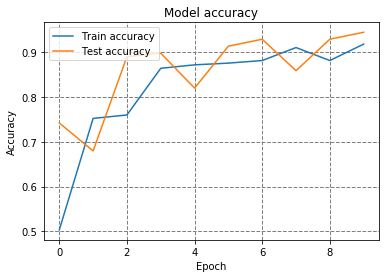

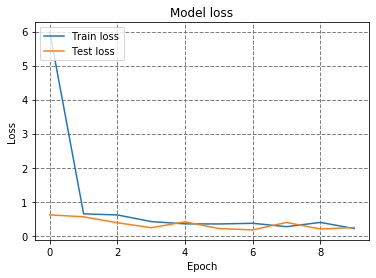

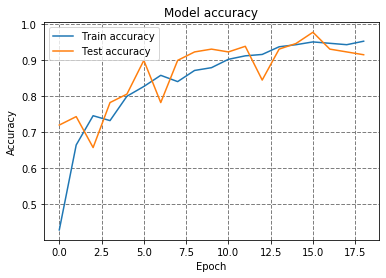

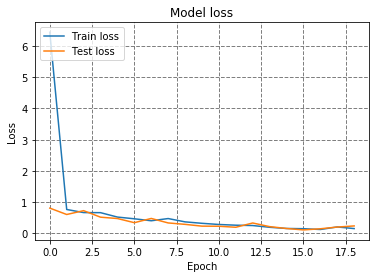

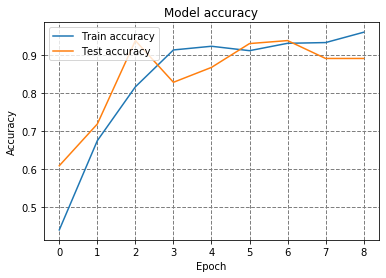

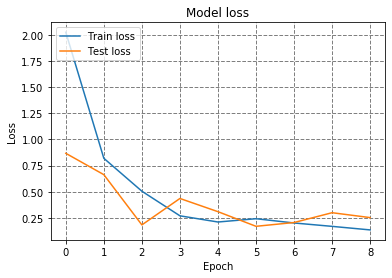

In [18]:
draw_history(history_default)
draw_history(history_cutout)
draw_history(history_albumentations)

In [19]:
print(history_default.history)

{'loss': [5.97857258721062, 0.6437197706916116, 0.6114871656410468, 0.41629520635079137, 0.3494186554702154, 0.3465414321341874, 0.3660640511049293, 0.2666630924497398, 0.39233811819345854, 0.21211223458471334], 'categorical_accuracy': [0.5029014, 0.7524178, 0.7601547, 0.86460346, 0.87234044, 0.8762089, 0.8820116, 0.91102517, 0.8820116, 0.9187621], 'val_loss': [0.6140324734151363, 0.5567433312535286, 0.38146861642599106, 0.235931274946779, 0.40853239595890045, 0.21308947540819645, 0.1715003876015544, 0.3912242678925395, 0.19806537311524153, 0.24180292850360274], 'val_categorical_accuracy': [0.7421875, 0.6796875, 0.890625, 0.8984375, 0.8203125, 0.9140625, 0.9296875, 0.859375, 0.9296875, 0.9453125]}


Test our models


Found 158 images belonging to 3 classes.
Found 0 images belonging to 3 classes.


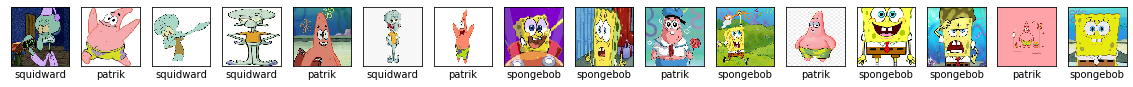

In [6]:
test_data_path = './dataset/test/'

image_generator_test =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.,
)

test_dataset, _ = make_dataset(image_generator_test, test_data_path)
ex = test_dataset[0]
draw_examples(ex)
print(test_dataset)


Load test dataset

In [7]:
results = {}

In [8]:
model = tf.keras.models.load_model("model_default.h5")

In [9]:
result = model.evaluate(test_dataset)
results["default"] = result

  ...
    to  
  ['...']
10/10 [==============================] - 1s 149ms/step - loss: 0.1761 - categorical_accuracy: 0.9367


In [10]:
model = tf.keras.models.load_model("model_cutout.h5")

In [11]:
result = model.evaluate(test_dataset)
results["cutout"]  = result

  ...
    to  
  ['...']
10/10 [==============================] - 0s 36ms/step - loss: 0.1650 - categorical_accuracy: 0.9620


In [12]:
model = tf.keras.models.load_model("model_albumentations.h5")

In [13]:
result = model.evaluate(test_dataset)
results["albumentations"]  = result

  ...
    to  
  ['...']
10/10 [==============================] - 0s 29ms/step - loss: 0.1501 - categorical_accuracy: 0.9367


In [16]:
!pip -q install tabulate
from tabulate import tabulate
headers = ["augmentation type", "loss", "categorical accuracy"]
print(tabulate([[k,] + v for k,v in results.items()], headers = headers))


augmentation type        loss    categorical accuracy
-------------------  --------  ----------------------
default              0.17609                 0.936709
cutout               0.165028                0.962025
albumentations       0.150102                0.936709
